## Importacion liberias

In [4]:
import torch.nn as nn
import torch
#from torch.utils.data import Dataset, DataLoader
import os
import sys
import json
import numpy as np
import pandas as pd
import datasets as ds
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoConfig, EarlyStoppingCallback
)
from transformers.integrations import TensorBoardCallback
from transformers import EvalPrediction
from sklearn.metrics import f1_score, recall_score, precision_score
from torcheval.metrics import MulticlassAccuracy
from typing import Dict, List, Tuple
from datasets import DatasetDict, load_dataset
from sklearn.model_selection import train_test_split
from code.visualization import Eda

ImportError: attempted relative import with no known parent package

## Versiones, sys info, device ...

In [ ]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Device name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(torch.cuda.get_arch_list())

# sys, library info
print("Operating System:", os.name)
print("Platform:", sys.platform)
print("Current Working Directory:", os.getcwd())
print("Environment Variables:", os.environ)
print("Python Version:", sys.version)
print("Command-line arguments:", sys.argv)
print(ds.__version__)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## EDA

In [7]:
df = pd.read_csv("./data/data_tw.csv")
df.drop(columns = 	'Unnamed: 0', inplace = True)

In [8]:
df.head()

,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label
0,637894677824413696,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed w...,1013187241,84,211,251,837,0,1
1,637890384576778240,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning t...",1013187241,84,211,251,837,1,1
2,637749345908051968,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain ...,1013187241,84,211,251,837,0,1
3,637696421077123073,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and...,1013187241,84,211,251,837,2,1
4,637696327485366272,Sat Aug 29 18:40:26 +0000 2015,It’s hard to say whether packing lists are mak...,1013187241,84,211,251,837,1,1


In [9]:
df["label"].value_counts()

label
1    10000
0    10000
Name: count, dtype: int64

In [10]:
df.columns

Index(['post_id', 'post_created', 'post_text', 'user_id', 'followers',
       'friends', 'favourites', 'statuses', 'retweets', 'label'],
      dtype='object')

In [11]:
df.shape

(20000, 10)

In [12]:
labels = df['label'].unique()

In [13]:
labels

array([1, 0])

array([[<Axes: title={'center': 'post_id'}>,
        <Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'followers'}>],
       [<Axes: title={'center': 'friends'}>,
        <Axes: title={'center': 'favourites'}>,
        <Axes: title={'center': 'statuses'}>],
       [<Axes: title={'center': 'retweets'}>,
        <Axes: title={'center': 'label'}>, <Axes: >]], dtype=object)

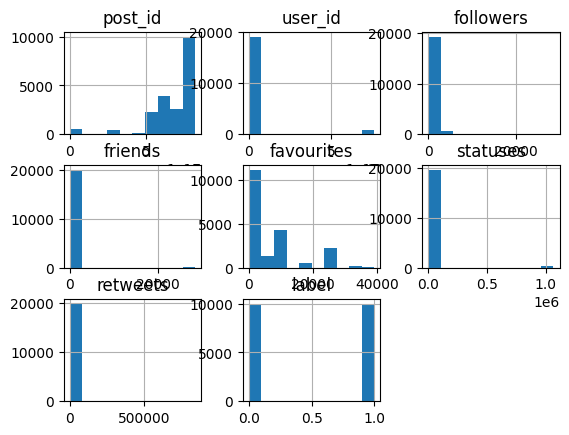

In [14]:
df.hist()

In [ ]:
tw_eda = Eda(data = df, auto_eda = False, target_var  = "label")

In [ ]:
# Columnas categoricas del df
tw_eda.cat_cols

In [ ]:
# Columnas numericas del df
tw_eda.infonum

In [ ]:
# Histogramas de las vraiables numericas
tw_eda.plot_hist(
                        bins = 100 ,
                        divide_feature = None,
                        layout = 'constrained',
                        fig_x_size = 14 ,
                        fig_y_size = 8,
                        fig_rows = 1 ,
                        fig_cols = 2 ,
                        linewidth = 0.5 ,
                        density = True,
                        stacked = True
                      )

In [ ]:
# Diagramas de barras 
tw_eda.plot_bar(
            layout = 'constrained',
            rotation = 0 ,
            fig_x_size = 10,
            fig_y_size = 10,
            fig_rows = 1,
            fig_cols = 1 ,
            plot_limit_categories = 50    
         )

In [ ]:
# Diagramas de barras combinados
tw_eda.plot_combined_bar(
                                layout = 'constrained',
                                fig_x_size = 10,
                                fig_cols = 1,
                                value_feature =  ['followers','friends', 'favourites', 'statuses', 'retweets'],
                                target_feature = "label",
                                max_categories = 10,
                                divide_feature = None,
                                errorbar = None,
                                estimator = np.mean, # Estimator puede ser un callable (es decir funcion) np.mean, np.sum o 'sum', ... funciones de numpy que se apliquen a un vector
                                                    # np.mean te hace la media de todo el vestor y te la plotea en el eje y
                                                    # np.sum te suma todo el vector y te lo plotea en el eje y
                                color = 0,
                                )

In [ ]:
# mapa de calor de la matriz de correlacion (coeficientes de pearson entre cada par de features numericas)
tw_eda.plot_corr_heatmap(
                                fig_x_size = 10, 
                                fig_y_size = 8, 
                                layout = 'constrained' , 
                                linewidth = 0.5, 
                                cmap = 'coolwarm', # 'Set1', 'Set2', 'Set3', 'Paired','Accent', 'Prism', 'Dark2','Paired', 'coolwarm', 'viridis', 'cubehelix'
                                annot = True, # If True, plot el valor numerico de corrrelacion (entre variables) en la celda del mapa de calor
                                fmt = '.2f' # Especificacion del formato numerico
                                
                                )

In [ ]:
# Scatter plot contra labels
tw_eda.plot_scatter(
                            fig_x_size = 14, 
                            fig_cols = 2,
                            linewidth =  0.5,  
                            layout = 'constrained' , 
                            x =   ['followers','friends', 'favourites', 'statuses', 'retweets'], 
                            y = ["label"], 
                            size = "followers", 
                            hue = "friends", 
                            color = 0, 
                            plotting_lib = 'plotly', 
                            umbral = 10, 
                            show_outliers = False, 
                            plotly_opacity = 0.6,
                            plotly_colorscale = 20, #[19,20,21,22,23,24]
                            plotly_bgcolor = None ,# str or none
                            save_figure = None, #["jpeg","png","WebP",None]
                            name_figure = "Fig"  
                            )

## Preprocesamiento

## Creacion dataset de entrenamiento [HG Dataset]

In [15]:
# util functions
def get_current_utc_date_iso():
    # Get the current date and time in UTC and format it directly
    return datetime.now(timezone.utc).strftime("%Y%m%d%H%M%S")

In [16]:
class TwDataset:
  def __init__(self, tokenizer,df, text_field_name, label_field_name, id_field_name):
    self.tokenizer = tokenizer
    self.data = df
    try:
      self.labels = df[label_field_name].unique()
    except Exception as e:
      print(e)
    self.label2id = {l:i for i,l in enumerate(self.labels)}
    self.id2label = {i:l for i,l in enumerate(self.labels)}
    self.text_f_name = text_field_name
    self.label_f_name = label_field_name
    if id_field_name:
      self.id_field_name = id_field_name
      self.ids = {k:[] for k in id_field_name}
      print('ID FIELDS :',self.ids)
    self.tokens = []
    self.len_texts = []


  def _tokenize_texts(self, texts : List[str], tensor :bool = False):
    if isinstance(texts , list):
      if self.tokenizer is not None:
        if tensor:
          x = self.tokenizer(texts, padding=True, truncation=True,  return_tensors="pt")
        else:
          x = self.tokenizer(texts, padding=True, truncation=True)
        return x
      else:
        raise ValueError('No tokenizer passed as argument')


  def _process_dataset(self, dataset) -> dict:
      text_name_field = self.text_f_name if isinstance(self.text_f_name, str) else None
      if text_name_field is None:
          raise AttributeError("Text field name must be str")

      text = str(dataset[text_name_field]) # aseguramos tipo de dato es str

      # tokenizacion
      tokenized = self.tokenizer(text, padding=False, truncation=True)

      # calculo de tokens , caracteres y ids por texto
      self.tokens.append(len(tokenized["input_ids"]))
      self.len_texts.append(len(text))
      for id_i in self.ids.keys():
        self.ids[id_i].append(dataset[id_i])

      # labels
      tokenized["labels"] = dataset[self.label_f_name]

      return tokenized


  def get_hg_dataset(self, split : bool = False, tokenize :bool = True, from_csv: bool =False, csv_path :str = None ):

      # load original dataset from path
      if from_csv:
        try:
          dataset = load_dataset("csv", data_files=csv_path, split = 'train')
          try:
            dataset = dataset.remove_columns(["Unnamed: 0"])
          except:
            pass
          print(dataset)
        except Exception as e:
            print(e)
        if split:
          dataset_train_test = dataset.train_test_split(test_size = 0.2, shuffle = True, seed =42)
          dataset_train_val = dataset_train_test["train"].train_test_split(test_size = 0.1, shuffle = True, seed =42)
          dataset = DatasetDict({
                                                  "train": dataset_train_val["train"],
                                                  "validation": dataset_train_val["test"],
                                                  "test":dataset_train_test["test"]
                                                  })
      else:
        try:
            if split:
                # test 20 % train
                df_train_val, df_test = train_test_split(self.data, test_size=0.2, random_state=42)
                print('\n---------------------------------------------------')
                print("Test df shape : ", df_test.shape)
                # Validation 10% de train
                df_train, df_val = train_test_split(df_train_val, test_size=0.1, random_state=42)
                print("Train df shape : ", df_train.shape)
                print("validation df shape : ", df_val.shape)
                print('---------------------------------------------------\n')


                dataset = DatasetDict({
                                                    "train": ds.from_pandas(df_train),
                                                    "validation": ds.from_pandas(df_val),
                                                    "test":ds.from_pandas(df_test)
                                                    })
            else:
                dataset = DatasetDict({
                                    "train": ds.from_pandas(self.data)
                                    })

            dataset = dataset.remove_columns(["Unnamed: 0"])
            print("\nHG DATASET :\n ", dataset)
            #dataset = load_dataset(self.path).remove_columns(["Unnamed: 0"])
        except Exception as e:
            print(e)


      if tokenize:
          dataset_tokenize = dataset.map(self._process_dataset, batched=False, remove_columns=self.data.columns.tolist())
      else:
          dataset_tokenize = None
      print("\nHG DATASET TOKENIZE:\n ", dataset_tokenize)
      return dataset,dataset_tokenize

  def get_plots(self, dir_path: str, figure_name: str, show : bool = False):

      def addlabels(x, y, text, size, rotation):
          colors = ['g', 'r', 'c', 'm', 'y', 'k']  # Removed 'b' (blue) from the list
          c = 0
          for i in range(len(x)):
              if c >= len(colors):
                  c = 0
              plt.annotate(text[i], (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center', size=size, color=colors[c], rotation=rotation)
              c += 1

      # Calculate the number of tokens for each document
      if self.tokens and self.len_texts:

          # Plotting the histogram of token counts
          plt.figure(figsize=(10, 6))
          plt.hist(self.tokens, bins=30, color="blue", edgecolor="black", alpha=0.7)
          plt.title("Histogram of Token Counts")
          plt.xlabel("Token Count")
          plt.ylabel("Frequency")
          plt.grid(axis="y", alpha=0.75)
          if show:
            plt.show()
          else:
            plot_file = os.path.join(dir_path, get_current_utc_date_iso() + "_" + figure_name + "_" + "token_hist.png")
            plt.savefig(plot_file)
            plt.close()

          # Plotting the histogram of characters counts
          plt.figure(figsize=(10, 6))
          plt.hist(self.len_texts, bins=30, color="red", edgecolor="black", alpha=0.7)
          plt.title("Histogram of Character Counts")
          plt.xlabel("Character Count")
          plt.ylabel("Frequency")
          plt.grid(axis="y", alpha=0.75)
          if show:
            plt.show()
          else:
            plot_file = os.path.join(dir_path, get_current_utc_date_iso() + "_" + figure_name + "_" + "character_hist.png")
            plt.savefig(plot_file)
            plt.close()

          # Plotting ordered chunk vs num tokens
          SAMPLE_PLOT_SIZE = min(100, len(self.len_texts))
          NUM_CHUNKS = np.arange(SAMPLE_PLOT_SIZE)

          plt.figure(figsize=(10, 6))
          plt.bar(NUM_CHUNKS, self.tokens[:SAMPLE_PLOT_SIZE], color="blue", alpha=1)
          addlabels(NUM_CHUNKS, self.tokens[:SAMPLE_PLOT_SIZE], [str(t) for t in self.tokens[:SAMPLE_PLOT_SIZE]], 10, 0)
          for i,id_i in enumerate(self.id_field_name):
              plot_id = []
              for v in self.ids[id_i][:SAMPLE_PLOT_SIZE]:
                  plot_id.append('#'+ str(id_i)+':'+str(v))
              addlabels(
                          x = NUM_CHUNKS,
                          y = np.full(len(self.tokens[:SAMPLE_PLOT_SIZE]), np.max(self.tokens[:SAMPLE_PLOT_SIZE]))*(0.1*(i+1)),
                          text = plot_id,
                          size = 6,
                          rotation = 40)
          plt.title("Token counts per chunk index")
          plt.xlabel("CHUNK index")
          plt.ylabel("Token counts")
          plt.grid(axis="y", alpha=0.75)
          if show:
            plt.show()
          else:
            plot_file = os.path.join(dir_path, get_current_utc_date_iso() + "_" + figure_name + "_" + "num_token_per_chunk.png")
            plt.savefig(plot_file)
            plt.close()

          plt.figure(figsize=(10, 6))
          plt.bar(NUM_CHUNKS, self.len_texts[:SAMPLE_PLOT_SIZE], color="red", alpha=1)
          addlabels(NUM_CHUNKS, self.len_texts[:SAMPLE_PLOT_SIZE], [str(t) for t in self.len_texts[:SAMPLE_PLOT_SIZE]], 10, 0)
          for i,id_i in enumerate(self.id_field_name):
              plot_id = []
              for v in self.ids[id_i][:SAMPLE_PLOT_SIZE]:
                  plot_id.append('#'+ str(id_i)+':'+str(v))
              addlabels(
                          x = NUM_CHUNKS,
                          y = np.full(len(self.len_texts[:SAMPLE_PLOT_SIZE]), np.max(self.tokens[:SAMPLE_PLOT_SIZE]))*(0.2*(i+1)),
                          text = plot_id,
                          size = 6,
                          rotation = 40)
          plt.title("Character counts per chunk index")
          plt.xlabel("CHUNK index")
          plt.ylabel("Character counts")
          plt.grid(axis="y", alpha=0.75)
          if show:
            plt.show()
          else:
            plot_file = os.path.join(dir_path, get_current_utc_date_iso() + "_" + figure_name + "_" + "num_character_per_chunk.png")
            plt.savefig(plot_file)
            plt.close()


In [17]:
# MODEL
from transformers import AutoModel, AutoModel, AutoConfig
MODEL_NAME = 'microsoft/deberta-v3-base'
model = AutoModel.from_pretrained(MODEL_NAME)
config = AutoConfig.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback optio

In [18]:
dataset = TwDataset(
                    tokenizer =tokenizer ,
                    df = df,
                    text_field_name = 'post_text',
                    label_field_name = 'label',
                    id_field_name = ['post_id']
                    )
_, dataset_split = dataset.get_hg_dataset(split = True, tokenize = True, from_csv = True, csv_path = './data/data_tw.csv' )

ID FIELDS : {'post_id': []}
Dataset({
    features: ['post_id', 'post_created', 'post_text', 'user_id', 'followers', 'friends', 'favourites', 'statuses', 'retweets', 'label'],
    num_rows: 20000
})


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]


HG DATASET TOKENIZE:
  DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 14400
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 4000
    })
})


In [19]:
dataset_split["train"]["labels"][0:10]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 0]

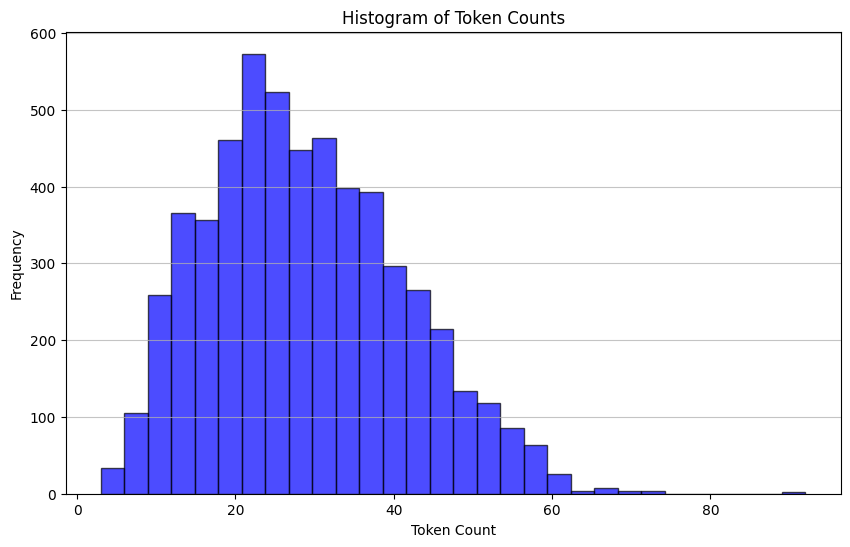

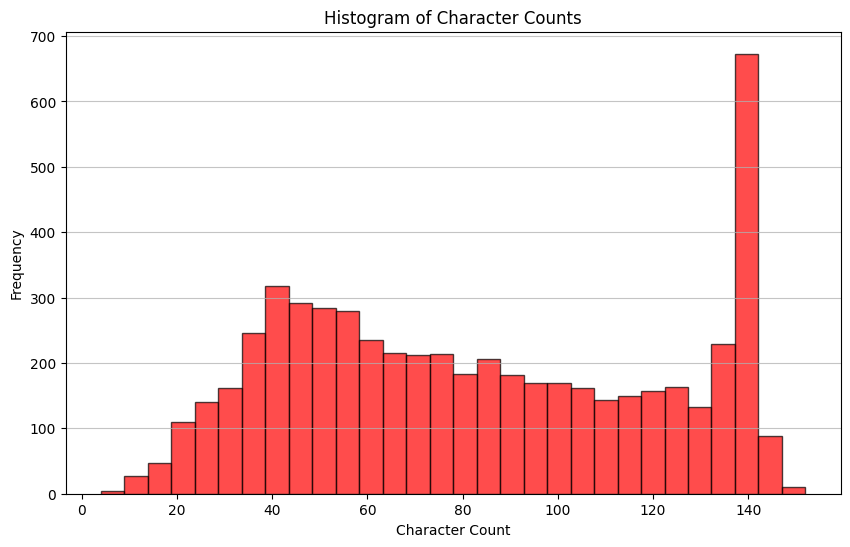

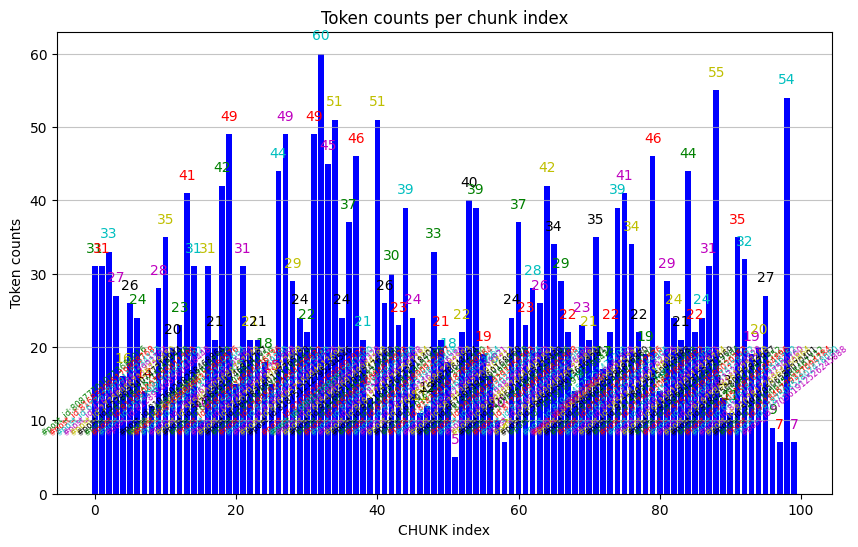

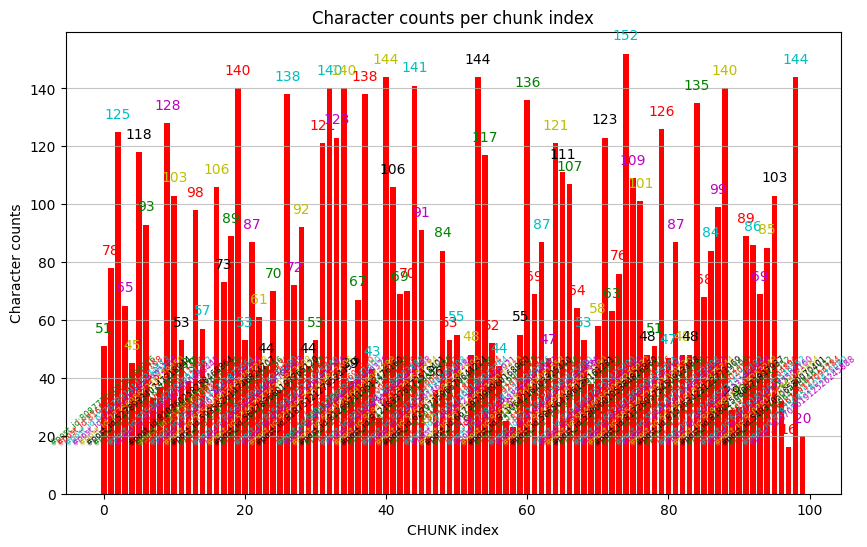

In [20]:
dataset.get_plots(dir_path = '/content/drive/MyDrive/NLP/data', figure_name = 'tw_fig', show = True)

### Clasifier class

#### Configuration for the classifier

In [21]:
FILE_PATH_CONF = './conf/model.json'
MODEL_CONFG ={
  "model": {
              "name": MODEL_NAME
          },
  "problem" : {
                "labels_to_pred" : [0,1]
  },
  "trainer":{
              "callbacks":{
                            "EarlyStoppingCallback": {
                                                        "early_stopping_patience":3,
                                                        "early_stopping_threshold":0.0
                                                      }
                          }
              },

  "metrics": {
              "type":
                    {
                    "f1": {"compute": True, "method": ["micro", "macro", "weighted","binary"]},
                    "recall": {"compute": True, "method": ["micro", "macro", "weighted","binary"]},
                    "MulticlassAccuracy": {"compute": True, "method": ["micro", "macro", "None"]},
                    "precision":{"compute": True, "method": ["micro", "macro", "weighted","binary"]}
                    },
                "optimize": {"name":"f1_macro"}
              },
  "training_args": {
                    "dir_path" : "./model/checkpoint",
                    "evaluation_strategy" : "epoch",
                    "report_to":"tensorboard",
                    "save_strategy" : "epoch",
                    "learning_rate":3e-05,
                    "per_device_train_batch_size":8,
                    "per_device_eval_batch_size":4,
                    "num_train_epochs":10,
                    "weight_decay":0.01,
                    "adam_epsilon":1e-08,
                    "load_best_model_at_end":True,
                    "metric_for_best_model":"f1_macro",
                    "gradient_accumulation_steps": 10,
                    "warmup_ratio":0.03,
                    "fp16_full_eval":False,
                    "fp16":False
                  }
}

with open(FILE_PATH_CONF, "w") as outfile:
    json.dump(MODEL_CONFG, outfile)

In [22]:
# MODULE CLASS DOCU:
"""nn.Module :
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in a tree structure. You can assign the submodules as regular attributes:
self.sub_module = nn.Linear(...)"""

os.environ['HF_TOKEN'] = 'ls__fe633ef5a71843baa5d07db00d83cd68'

# Util functions
def get_current_utc_date_iso():
    return datetime.now(timezone.utc).strftime("%Y%m%d%H%M%S")

class BertNet:

    def __init__(self, model_conf_path: str):
        self.config_path = model_conf_path
        self.config = self._parse_config()
        self.model_name = self._get_model_name()
        self.model_tokenizer = self._get_tokenizer()
        self.model_config = self._get_model_config()
        self.model = self._get_model()
        self.compute_metric_f = self._get_metrics()
        self.train_args = self._get_training_args()

    def _parse_config(self) -> Dict:
        if not os.path.exists(self.config_path):
            raise FileNotFoundError(f"Config file not found at {self.config_path}")
        with open(self.config_path, 'r') as file:
            config = json.load(file)
        return config

    def _get_model_name(self):
        model = self.config.get("model", {})
        model_name = model.get("name", None)
        if model_name is None:
            raise ValueError("Model name not defined in the model config file")
        return model_name

    def _get_model_config(self):
        problem = self.config.get("problem", {})
        self.labels = problem.get("labels_to_pred", None)
        if self.labels is None:
            raise ValueError("Labels to predict not defined in the model config file")
        self.id2label = {i: lab for i, lab in enumerate(self.labels)}
        self.label2id = {lab: i for i, lab in enumerate(self.labels)}
        try:
            return AutoConfig.from_pretrained(
                pretrained_model_name_or_path=self.model_name,
                num_labels=len(self.labels),
                id2label=self.id2label,
                label2id=self.label2id
            )
        except Exception as e:
            raise ValueError(f"Error in get Config Model method: {e}")

    def _get_model(self):
        try:
            return AutoModelForSequenceClassification.from_pretrained(self.model_name, config=self.model_config)
        except Exception as e:
            raise ValueError(f"Error in get Model method: {e}")

    def _get_tokenizer(self):
        try:
            return AutoTokenizer.from_pretrained(self.model_name)
        except Exception as e:
            raise ValueError(f"Error in get tokenizer method: {e}")

    def _get_metrics(self):
        metrics = self.config.get("metrics", {})
        self.metrics_to_compute = {metric: details["method"] for metric, details in metrics["type"].items() if details["compute"]}
        self.opt_metric = metrics.get("optimize", "")
        return self._get_compute_metric_f(metrics=self.metrics_to_compute)

    def _get_compute_metric_f(self, metrics: Dict[str, List[str]]):
        master_metric_mapper = {
            "f1_macro": f1_score,
            "f1_weighted": f1_score,
            "f1_binary": f1_score,
            "MulticlassAccuracy_micro": MulticlassAccuracy(average='micro', num_classes=4, k=1),
            "MulticlassAccuracy_macro": MulticlassAccuracy(average='macro', num_classes=4, k=1),
            "MulticlassAccuracy_None": MulticlassAccuracy(average=None, num_classes=4, k=1),
            "recall_micro": recall_score,
            "recall_macro": recall_score,
            "recall_weighted": recall_score,
            "recall_binary": recall_score,
            "precision_micro": precision_score,
            "precision_macro": precision_score,
            "precision_weighted": precision_score,
            "precision_binary": precision_score
        }
        self._metric_obj = {}
        for metric, methods in metrics.items():
            for method in methods:
                key_name = metric + "_" + method
                metric_obj = master_metric_mapper.get(key_name, None)
                if metric_obj is not None:
                    self._metric_obj[key_name] = metric_obj

        def compute_metrics(pred: EvalPrediction):
            predictions, labels = pred
            predictions = torch.tensor(predictions)
            labels = torch.tensor(labels)

            pred_label = torch.argmax(predictions, dim=1)
            true_label = torch.argmax(labels, dim=1)

            metric_results = {}
            for m_name, metric in self._metric_obj.items():
                metric_name, method = m_name.rsplit('_', 1)
                if metric_name in ["f1", "precision", "recall"]:
                    metric_results[m_name] = metric(y_true=true_label, y_pred=pred_label, average=method)
                elif metric_name == "MulticlassAccuracy":
                    metric.update(pred_label, true_label)
                    metric_results[m_name] = metric.compute()

            cross_entropy_loss_f = nn.CrossEntropyLoss()
            loss = cross_entropy_loss_f(predictions, labels)
            metric_results["Train Cross entropy loss"] = loss.item()
            metric_results["Inverse Train Cross entropy loss"] = 1 / loss.item()

            return metric_results
        return compute_metrics

    def _get_training_args(self):
        training_args = self.config.get("training_args", {})
        return TrainingArguments(
            training_args.get("dir_path", "./MODEL/DEFAULT"),
            evaluation_strategy=training_args.get("evaluation_strategy", "epoch"),
            report_to=training_args.get("report_to", "tensorboard"),
            save_strategy=training_args.get("save_strategy", "epoch"),
            learning_rate=training_args.get("learning_rate", 3e-05),
            per_device_train_batch_size=training_args.get("per_device_train_batch_size", 20),
            per_device_eval_batch_size=training_args.get("per_device_eval_batch_size", 32),
            num_train_epochs=training_args.get("num_train_epochs", 3),  # Ajustado para tiempos de prueba
            weight_decay=training_args.get("weight_decay", 0.01),
            adam_epsilon=training_args.get("adam_epsilon", 1e-08),
            load_best_model_at_end=training_args.get("load_best_model_at_end", True),
            metric_for_best_model=training_args.get("metric_for_best_model", self.opt_metric),
            gradient_accumulation_steps=training_args.get("gradient_accumulation_steps", 10),
            warmup_ratio=training_args.get("warmup_ratio", 0.03),
            fp16_full_eval=training_args.get("fp16_full_eval", False),
            fp16=training_args.get("fp16", True)
        )

    def _get_trainer(self, dataset: DatasetDict):
        trainer_config = self.config.get("trainer", {})
        callbacks_args = trainer_config.get("callbacks", {})
        early_stopping_args = callbacks_args.get("EarlyStoppingCallback", {})

        return Trainer(
            model=self.model,
            args=self.train_args,
            train_dataset=dataset["train"],
            eval_dataset=dataset["validation"],
            tokenizer=self.model_tokenizer,
            compute_metrics=self.compute_metric_f,
            callbacks=[
                EarlyStoppingCallback(
                    early_stopping_patience=early_stopping_args.get("early_stopping_patience", 3),
                    early_stopping_threshold=early_stopping_args.get("early_stopping_threshold", 0.0)
                ),
                TensorBoardCallback()
            ]
        )

    def trainer(self, dataset: DatasetDict):
        self.trainer = self._get_trainer(dataset)
        return self.trainer

    def predict(self, dataset: DatasetDict):
        try:
            return self.trainer.evaluate(dataset["test"])
        except Exception as e:
            raise ValueError(f"Error in predict method: {e}")



In [25]:
tw_bert = BertNet(FILE_PATH_CONF)
trainer = tw_bert.trainer(dataset_split)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are adding a <class 'transformers.integrations.integration_utils.TensorBoardCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback
EarlyStoppingCallback


In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
results = trainer.evaluate(dataset_split["test"])
print(results)